In [1]:
import pandas as pd
from scipy import stats
from ast import literal_eval
from helper_functions import *
import warnings
warnings.filterwarnings('ignore')

In [2]:
comments_2020 = read_2020()
comments_2019 = read_2019()

In [3]:
keywords = pd.read_csv('../data/keyword_articles.csv')
keywords = keywords.drop(keywords.columns[[0,2]], axis=1)

In [4]:
#amount of total and empty comments posted in 2020
total(comments_2020)

Total amount of comments: 32149044
Amount of NaN-comments: 992700


In [5]:
#number of articles 2020
print(len(pd.unique(comments_2020['ID_GodotObject'])))

88680


In [6]:
#number of articles 2019
print(len(pd.unique(comments_2019['ID_GodotObject'])))

56509


In [7]:
#amount of total and empty comments posted in 2020
total(comments_2019)

Total amount of comments: 10410491
Amount of NaN-comments: 453541


## Extract COVID-19 related articles

In [8]:
#combine the comments with the respective keywords
merged_2020 = pd.merge(comments_2020,keywords)

In [9]:
total(merged_2020)

Total amount of comments: 31277599
Amount of NaN-comments: 970117


In [11]:
#some articles are not contained in the merged data frame and therefore lack content details or classification
#inspect the differences
diff = pd.concat([merged_2020.drop([merged_2020.columns[5],merged_2020.columns[6]],axis=1),comments_2020]).drop_duplicates(keep=False)

In [12]:
#filter articles with no details
no_details = pd.DataFrame(pd.unique(diff['ID_GodotObject']))

In [14]:
#export for external checks
no_details.to_csv('../data/no_details_2020-21.csv')

In [15]:
#add missing keywords
missing_articles = pd.read_csv('../data/missing_articles.csv')

In [16]:
#include reinclude former unclassified comments
merged_2020_missing = comments_2020.join(missing_articles,on = 'ID_GodotObject', how='left', rsuffix='other')
merged_2020_missing = merged_2020_missing.drop(merged_2020_missing.columns[[5,6,8,9,10,11]], axis=1)
merged_2020_missing = merged_2020_missing[~merged_2020_missing['keyword'].isnull()]

In [17]:
len(merged_2020_missing)

0

In [18]:
merged_2020_final = pd.concat([merged_2020.reset_index(),merged_2020_missing.reset_index()])
merged_2020_final = merged_2020_final.drop(merged_2020_final.columns[0],axis=1)

In [19]:
len(merged_2020_final)

31277599

In [20]:
#get all keywords to filter COVID related articles
#only keep unique articles to reduce computational cost
unique_articles = merged_2020_final.drop_duplicates(subset='ID_GodotObject').reset_index(drop=True)
unique_articles = unique_articles.loc[unique_articles['keyword'].isna() == False]
keys = sorted(set(unique_articles.keyword.apply(literal_eval).sum()))

In [21]:
print('There are', len(keys), 'different unique keywords.')

There are 64054 different unique keywords.


In [22]:
#filter for COVID-19 related substrings
covid_keys = []
for i in keys:
    if 'Corona' in i or 'corona' in i or 'Covid' in i or 'covid' in i or 'COVID' in i or 'SARS' in i:
        covid_keys.append(i)

In [23]:
covid_keys

['COVID-19',
 'Corona-Krise',
 'Coronaabsage',
 'Coronaaktivismus',
 'Coronaauflage',
 'Coronabericht',
 'Coronabeschränkung',
 'Coronabond',
 'Coronaboom',
 'Coronabudget',
 'Coronaeffekt',
 'Coronafall',
 'Coronafolge',
 'Coronafonds',
 'Coronaforschung',
 'Coronagebet',
 'Coronagesetz',
 'Coronahilfsgeld',
 'Coronaimpfung',
 'Coronainfektion',
 'Coronainfektionsrisiko',
 'Coronainformation',
 'Coronajahr',
 'Coronalockerung',
 'Coronamaßnahme',
 'Coronamilieu',
 'Coronapause',
 'Coronapolitik',
 'Coronarabatt',
 'Coronarezession',
 'Coronarisiko',
 'Coronaschock',
 'Coronasituation',
 'Coronasperre',
 'Coronaspielzeit',
 'Coronastrategie',
 'Coronastufe',
 'Coronatest',
 'Coronatickercommunity',
 'Coronaunterstützung',
 'Coronaverbrechen',
 'Coronavirenschleuder',
 'Coronavirus',
 'Coronavirus-Krise',
 'Coronavirusbezug',
 'Coronavirusfall',
 'Coronavirusgebiet',
 'Coronavirusinfektion',
 'Coronaviruspandemie',
 'Coronavorschrift',
 'Coronawahn',
 'Coronawelle',
 'Coronawoche',
 'Co

In [23]:
print('There are', len(covid_keys), 'different keywords containing COVID or a synonym of it.')

There are 58 different keywords containing COVID or a synonym of it.


In [24]:
#extract comments under COVID-19 related articles by keyword-list
covid_article_ids = unique_articles['ID_GodotObject'].loc[unique_articles['keyword'].apply(lambda x: any(n in x for n in covid_keys))]
print('There are', len(covid_article_ids),'COVID-19 related articles.')
covid_comments = merged_2020_final.loc[merged_2020_final['ID_GodotObject'].isin(list(covid_article_ids))]
print('With',len(covid_comments),'comments.')

There are 14165 COVID-19 related articles.
With 14391704 comments.


In [25]:
print('The first comment under a COVID-19 related article was posted on',min(covid_comments['createdAt']))

The first comment under a COVID-19 related article was posted on 2020-01-06 18:01:55.497


In [26]:
#extract non-COVID-19 related articles
non_covid_comments = merged_2020_final.loc[merged_2020_final['ID_GodotObject'].isin(list(covid_article_ids))==False]
print('There are',len(non_covid_comments),'comments under non-COVID-19 articles.')

There are 16885895 comments under non-COVID-19 articles.


## Data Exploration (01/2020-11/2021; all articles)

In [27]:
merged_2020_final = merged_2020_final.loc[merged_2020_final["Comment"].isna()==False]
#remove all comments posted before the first COVID-related comment
merged_2020_final = merged_2020_final.loc[merged_2020_final['createdAt']>min(covid_comments['createdAt'])]
print('There are',len(merged_2020_final),'non-empty comments.')

There are 30169027 non-empty comments.


In [28]:
#get value counts of unique users and articles
count_user = merged_2020_final['ID_CommunityIdentity'].value_counts()
count_article = merged_2020_final['ID_GodotObject'].value_counts()

In [29]:
stats(merged_2020_final,count_user,count_article)

Number of unique users: 93513
Mean comments per user: 322.61853432143124
With a standard deviation of: 1716.8779245272572
Number of unique articles: 82777
Mean comments per article: 364.46146876547834
With a standard deviation of: 1797.3214509727882


In [30]:
count_user.quantile(0.99)

5860.0

In [31]:
count_article.quantile(0.99)

3647.080000000089

In [125]:
text_stats(merged_2020_final)

Maximum number of characters: 1496
Minimum number of characters: 1
Mean number of characters: 159.42050524201525
Maximum number of words: 591
Minimum number of words: 1
Mean number of words: 23.554723790064557
Amount of comments with exactly one word: 1353139


In [126]:
#count words per comment and store it into a new colum
merged_2020_final['Word Count'] = merged_2020_final['Comment'].str.count(' ').add(1)

In [127]:
#calculate 0.99 quantile to remove overtly long comments 
merged_quantile = merged_2020_final['Word Count'].quantile(0.99)

In [128]:
merged_quantile

110.0

array([[<AxesSubplot: title={'center': 'Word Count'}>]], dtype=object)

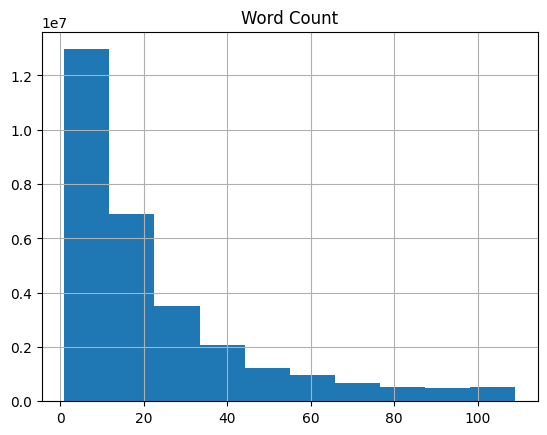

In [32]:
merged_2020_final[merged_2020_final['Word Count']<merged_quantile].hist(column='Word Count')

## Data Exploration (01/2020-11/2021; COVID-19 articles)

In [32]:
covid_comments = covid_comments.loc[covid_comments["Comment"].isna()==False]
print('There are',len(covid_comments),'non-empty comments.')

There are 14016469 non-empty comments.


In [33]:
count_user_covid = covid_comments['ID_CommunityIdentity'].value_counts()
count_article_covid = covid_comments['ID_GodotObject'].value_counts()

In [34]:
count_article_covid.quantile(0.5)

158.0

In [35]:
count_article_covid.median()

158.0

In [36]:
stats(covid_comments,count_user_covid,count_article_covid)

Number of unique users: 64401
Mean comments per user: 217.64365460163663
With a standard deviation of: 1515.347587011008
Number of unique articles: 14135
Mean comments per article: 991.6143615139724
With a standard deviation of: 3638.183729292492


In [36]:
count_user_covid.quantile(0.99)

3628.0

In [37]:
count_article_covid.quantile(0.99)

18594.779999999988

In [38]:
text_stats(covid_comments)

Maximum number of characters: 1492
Minimum number of characters: 1
Mean number of characters: 133.50374277573047
Maximum number of words: 577
Minimum number of words: 1
Mean number of words: 19.762779912686998
Amount of comments with exactly one word: 803244


In [113]:
covid_comments['Word Count'] = covid_comments['Comment'].str.count(' ').add(1)

In [40]:
covid_comments['Word Count'].quantile(0.99)

107.0

array([[<AxesSubplot: title={'center': 'Word Count'}>]], dtype=object)

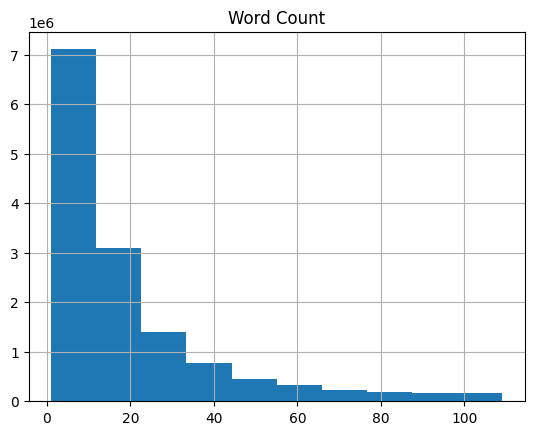

In [41]:
covid_comments[covid_comments['Word Count']<merged_quantile].hist(column='Word Count')

In [42]:
covid_comments_length = covid_comments.loc[(covid_comments['Word Count'] >10) & (covid_comments['Word Count'] <merged_quantile)]

In [43]:
covid_comments_length[['Comment', 'ID_Posting']].to_csv('../data/covid_sample.csv', header = True, index = False)

## Data Exploration (01/2020-11/2021; non-COVID-19 articles)

In [37]:
non_covid_comments = non_covid_comments.loc[non_covid_comments["Comment"].isna()==False]
non_covid_comments = non_covid_comments.loc[non_covid_comments['createdAt']>min(covid_comments['createdAt'])]
print('There are',len(non_covid_comments),'non-empty comments.')

There are 16152559 non-empty comments.


In [38]:
count_user_non_covid = non_covid_comments['ID_CommunityIdentity'].value_counts()
count_article_non_covid = non_covid_comments['ID_GodotObject'].value_counts()

In [39]:
stats(non_covid_comments,count_user_non_covid,count_article_non_covid)

Number of unique users: 82354
Mean comments per user: 196.1356946839255
With a standard deviation of: 806.4199693155437
Number of unique articles: 68642
Mean comments per article: 235.31597272806735
With a standard deviation of: 1035.5575515378098


In [47]:
count_user_non_covid.quantile(0.99)

3331.4100000000035

In [48]:
count_article_non_covid.quantile(0.75)

2113.0

In [49]:
text_stats(non_covid_comments)

Maximum number of characters: 1496
Minimum number of characters: 1
Mean number of characters: 181.9099122312446
Maximum number of words: 591
Minimum number of words: 1
Mean number of words: 26.84520297991173
Amount of comments with exactly one word: 549895


In [133]:
len(non_covid_comments.loc[(non_covid_comments['Word Count'] >merged_quantile)])+len(covid_comments.loc[(covid_comments['Word Count'] >merged_quantile)])+len(merged_2019_final.loc[(merged_2019_final['Word Count'] >merged_quantile)])

413270

In [114]:
non_covid_comments['Word Count'] = non_covid_comments['Comment'].str.count(' ').add(1)

In [51]:
non_covid_comments['Word Count'].quantile(0.99)

112.0

In [52]:
non_covid_comments_length = non_covid_comments.loc[(non_covid_comments['Word Count'] >10) & (non_covid_comments['Word Count'] <merged_quantile)]

In [53]:
non_covid_comments_length[['Comment', 'ID_Posting']].to_csv('../data/non_covid_sample.csv', header=True, index = False)

## Data Exploration (reference data from 2019)

In [40]:
merged_2019 = pd.merge(comments_2019,keywords)
total(merged_2019)

Total amount of comments: 9682153
Amount of NaN-comments: 431912


In [41]:
merged_2019_missing = comments_2019.join(missing_articles,on = 'ID_GodotObject',how='left', rsuffix='other')
merged_2019_missing = merged_2019_missing.drop(merged_2019_missing.columns[[5,6,8,9,10,11]], axis=1)
merged_2019_missing = merged_2019_missing[~merged_2019_missing['keyword'].isnull()]

In [42]:
merged_2019_final = pd.concat([merged_2019.reset_index(),merged_2019_missing.reset_index()])
merged_2019_final = merged_2019_final.drop(merged_2019_final.columns[0],axis=1)

In [43]:
#test if there where any COVID-19 related articles in 2019
unique_articles_2019 = merged_2019_final.drop_duplicates(subset='ID_GodotObject').reset_index(drop=True)
unique_articles_2019 = unique_articles_2019.loc[unique_articles_2019['keyword'].isna() == False]
covid_article_ids_2019 = unique_articles_2019['ID_GodotObject'].loc[unique_articles_2019['keyword'].apply(lambda x: any(n in x for n in covid_keys))]
print('There are', len(covid_article_ids_2019),'COVID-19 related articles.')
covid_comments_2019 = merged_2019_final.loc[merged_2019_final['ID_GodotObject'].isin(list(covid_article_ids_2019))]
print('With',len(covid_comments_2019),'comments.')

There are 0 COVID-19 related articles.
With 0 comments.


In [44]:
merged_2019_final = merged_2019_final.loc[merged_2019_final["Comment"].isna()==False]
print('There are',len(merged_2019_final),'non-empty comments.')

There are 9250241 non-empty comments.


In [45]:
count_user_2019 = merged_2019_final['ID_CommunityIdentity'].value_counts()
count_article_2019 = merged_2019_final['ID_GodotObject'].value_counts()

In [50]:
count_user_covid.median()

8.0

In [47]:
stats(merged_2019_final,count_user_2019,count_article_2019)

Number of unique users: 55780
Mean comments per user: 165.834367156687
With a standard deviation of: 648.4875933911954
Number of unique articles: 49421
Mean comments per article: 187.17227494384977
With a standard deviation of: 777.3675812633647


In [61]:
count_user_2019.quantile(0.99)

2776.209999999999

In [62]:
count_article_2019.quantile(0.99)

1815.800000000003

In [63]:
text_stats(merged_2019_final)

Maximum number of characters: 1487
Minimum number of characters: 1
Mean number of characters: 179.95249431879668
Maximum number of words: 572
Minimum number of words: 1
Mean number of words: 26.526039483728045
Amount of comments with exactly one word: 310400


In [115]:
merged_2019_final['Word Count'] = merged_2019_final['Comment'].str.count(' ').add(1)

In [65]:
merged_2019_final['Word Count'].quantile(0.99)

112.0

In [66]:
merged_2019_final_length = merged_2019_final.loc[(merged_2019_final['Word Count'] >10) & (merged_2019_final['Word Count'] <merged_quantile)]

In [67]:
merged_2019_final_length[['Comment', 'ID_Posting']].to_csv('../data/2019_reference_sample.csv', header = True, index = False)